In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
import matplotlib as mpl
import matplotlib.pylab as pl
# import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.tri as tri
import decimal
from scipy.integrate import simps


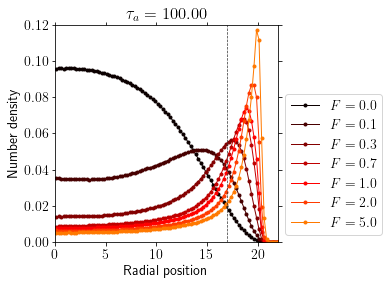

In [87]:
mpl.rcParams.update({'font.size':14, 'text.usetex':True})
fig,ax=plt.subplots(1,1,figsize=(4,4),gridspec_kw={'wspace':0.4, 'hspace':0.4})


ind=4
fpath='../../data/SAC_exp_Esoft0/'
for (name,tp) in [('low',0.01),('mid',1.0), ('high',100.)]:
    Ts,Fs,Tas=[],[],[]
    Rmax=[]
    betas=[]

    ax.clear()
    colors = pl.cm.hot(np.linspace(0,1,12))
    count=0
    for fname in os.listdir(fpath+'RDP/'):
        if '.npz' in fname and 'RadNumDens' in fname:# and 'rep2' in fname:
            # print(fname.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)

            npzfile=np.load(fpath+'RDP/'+fname)
            beta=F**2*Ta/(0.1*T*0.0083)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
            Rmax.append(Rav)
            if F==0: Rav_eq=Rav

            if F==0 or Ta==tp:#F==0.0 or (F==3 and (Ta==1 or Ta==100)):
                # if 'RadNumDens_A' in fname:
                #     ax1.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f},{:.1f}$'.format(beta,F),lw=1)

                # elif 'RadNumDens_B' in fname:
                #     ax2.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f}$'.format(F),lw=1)
                # else:
                ax.plot(npzfile['bins'],npzfile['hist'], '.-',label='$F={:.1f}$'.format(F),lw=1, color=colors[count])
                count+=1
                ax.set_title('$\\tau_a={:.2f}$'.format(Ta))

    ax.set_xlabel('Radial position')
    ax.set_ylabel('Number density')
    ax.legend(loc='lower left', bbox_to_anchor=(1,0))
    ax.set_xlim(0,22)
    ax.axvline(17,c='0.2',ls='--',lw=0.7)
    # ax.set_yscale('log')
    ax.set_ylim(0,1.2e-1)
    fig.savefig(fpath+'plots/RDP_{}Ta.png'.format(name), dpi=300, bbox_inches='tight')


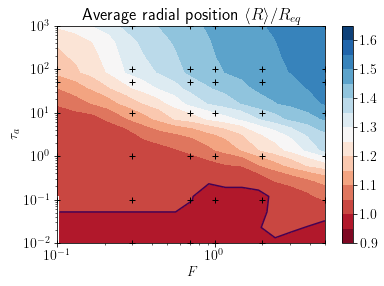

In [94]:
ax.clear()

Xi,Yi=np.meshgrid(np.geomspace(0.05,5,20),np.logspace(-2,3,15))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,np.around(np.array(Rmax)/Rav_eq, 2))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.9,1.7,0.05),cmap='RdBu')
plt.colorbar()
plt.contour(Xi, Yi, Zi, levels=[1])
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,Tas,'k+',)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,5)
plt.ylim(0.01,1e3)
plt.savefig(fpath+'plots/normAvgR_contour.png', dpi=300, bbox_inches='tight')


10


[]

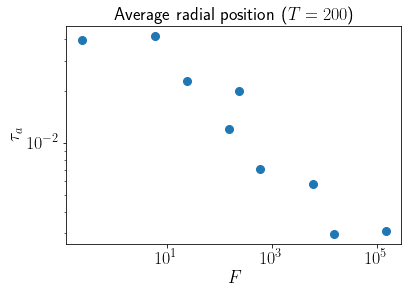

In [360]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=200
fpath='../../data/SAC_AB/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens_A' in fname and 'rep1' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        if kb==5: continue
        if T==T0:
            npzfile=np.load(fpath+fname)
       
            b_act=F**2*Ta/(0.1*0.0083*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
            Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
            Rsd=np.sqrt(simps((npzfile['bins']-Rav)**2*4*np.pi*npzfile['bins']*npzfile['hist']/1200,npzfile['bins']))
            # print(Rav)

            Rav=np.mean(npzfile['hist'][1:5])
            Rmax.append((F,Ta,b_act,Rav, Rsd**2/Rav))
        
print(len(Rmax))
Xi,Yi=np.meshgrid(np.logspace(-1,1,10),np.logspace(0,3,10))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,[xx[3] for xx in Rmax])#, kind='geom')
Zi=interpZ(Xi,Yi)
# plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,0.2,0.01),cmap='RdBu')
# plt.colorbar()
plt.plot([xx[2] for xx in Rmax],[xx[3] for xx in Rmax],'o')
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[10],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

# plt.plot(Fs,Tas,'.',c='b',markersize=5)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
plt.title('Average radial position ($T={:.0f}$)'.format(T0))

plt.loglog()
# plt.savefig('../../plots/Rouse/avg_radial_pos_Ft_T200.png', dpi=300,bbox_inches='tight')

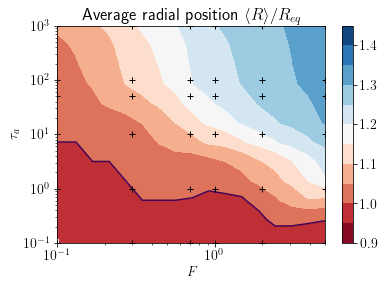

In [41]:
ind=4
# norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
# cmap = mpl.colors.gist_rainbow
# m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
Rav_eq=0
fpath='../../data/SAC_exp/RDP/'

for fname in os.listdir(fpath):
    if '.npz' in fname and 'RadNumDens' in fname:
        # print(fname)#.split('_'))
        T= float(fname.split('_')[ind].replace('T',''))
        F=float(fname.split('_')[ind+1].replace('F',''))
        Ta=float(fname.split('_')[ind+2].replace('Ta',''))
        kb=float(fname.split('_')[ind+7].replace('kb',''))
        Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
        R0=float(fname.split('_')[ind+4].replace('R0',''))
        dt=float(fname.split('_')[ind+8].replace('dt',''))
        # print(T,F,Ta,Esoft,R0)
        
        npzfile=np.load(fpath+fname)
    
        b_act=F**2*Ta/(0.1*0.0083*T)

        betas.append(b_act)
        Ts.append(T)
        Tas.append(Ta)
        Fs.append(F)
        Rav=simps(npzfile['bins']**3*4*np.pi*npzfile['hist']/1200,npzfile['bins'])
        Rm=npzfile['bins'][np.where(npzfile['hist']==npzfile['hist'].max())][0]
        Rmax.append(Rav)

        if F==0: Rav_eq=Rav

Xi,Yi=np.meshgrid(np.geomspace(0.05,5,20),np.logspace(-2,3,15))
triang=tri.Triangulation(Fs,Tas)
interpZ=tri.LinearTriInterpolator(triang,np.around(np.array(Rmax)/Rav_eq, 2))
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.9,1.5,0.05),cmap='RdBu')
plt.colorbar()
plt.contour(Xi, Yi, Zi, levels=[1])
# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Fs,Tas,'k+',)
plt.xlabel('$F$')
plt.ylabel('$\\tau_a$')
# plt.xlim(1,1e3)

plt.loglog()
plt.title('Average radial position $\\langle R\\rangle/R_{eq}$')
plt.xlim(0.1,5)
plt.ylim(0.1,1e3)
plt.savefig('../../data/SAC_exp/plots/normAvgR_contour.png', dpi=300, bbox_inches='tight')

In [34]:
ind=4

fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()

norm = mpl.colors.Normalize(vmin=0, vmax=0.6)
cmap = cm.gist_rainbow
m = cm.ScalarMappable(norm=norm, cmap=cmap)
# print(m.to_rgba(x))
Ts,Fs,Tas=[],[],[]
Rmax=[]
betas=[]
T0=100
for fpath in ['../../data/ROUSE_chain_confined_Ns/']:#,'../../data/ROUSE_chain_confined_Ns/N300/']:

    for fname in os.listdir(fpath):
        if '.npz' in fname and 'RDP' in fname:
            # print(fname)#.split('_'))
            T= float(fname.split('_')[ind].replace('T',''))
            F=float(fname.split('_')[ind+1].replace('F',''))
            Ta=float(fname.split('_')[ind+2].replace('Ta',''))
            kb=float(fname.split('_')[ind+7].replace('kb',''))
            Esoft=float(fname.split('_')[ind+3].replace('Esoft',''))
            R0=float(fname.split('_')[ind+4].replace('R0',''))
            dt=float(fname.split('_')[ind+8].replace('dt',''))
            # print(T,F,Ta,Esoft,R0)
            if R0!=10: continue
            npzfile=np.load(fpath+fname)
            # print(npzfile['bins'].shape)
        
            b_act=F**2*Ta/(0.1*T)

            betas.append(b_act)
            Ts.append(T)
            Tas.append(Ta)
            Fs.append(F)

            Rm=npzfile['bins'][np.where(npzfile['hist'][0]==npzfile['hist'][0].max())][0]
            Rmax.append(Rm/R0)

Xi,Yi=np.meshgrid(np.logspace(0,3,10),np.logspace(-3,3,20))
triang=tri.Triangulation(Tas, betas)
interpZ=tri.LinearTriInterpolator(triang,Rmax)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.arange(0.,1.2,0.1),cmap='RdBu')
plt.colorbar()

# cs= plt.contour(Xi,Yi,Xi**2*Yi/(0.1*0.0083*T0), colors='k', levels=[1, 10,1e2,1e3],)

# plt.clabel(cs, cs.levels, inline=True,fmt=fmt, fontsize=16)

plt.plot(Tas,betas,'.',c='b',markersize=5)

plt.loglog()


KeyboardInterrupt: 

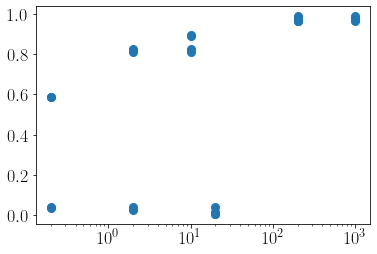

In [123]:
plt.semilogx(betas,Rmax,'o')

Text(0, 0.5, '$F^2\\tau_a/(\\gamma T)$')

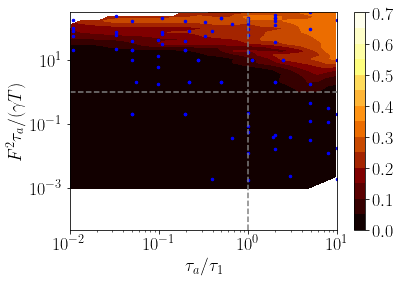

In [598]:
Xi,Yi=np.meshgrid(np.logspace(-3,2,50),np.logspace(-3,4,60))
triang=tri.Triangulation(X,Y)
interpZ=tri.LinearTriInterpolator(triang,Z)
Zi=interpZ(Xi,Yi)
plt.contourf(Xi, Yi, Zi, levels=np.linspace(0,0.7,15),cmap='afmhot')#,alpha=0.6)
        #ax.contour(Xi, Yi, Zi,colors='k',levels=levels,linewidths=0.3)


plt.plot(X,Y,'.',c='b',markersize=5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,10)
plt.ylim(5e-5,3e2)
plt.axhline(1,c='0.5',ls='--',)
plt.axvline(1,c='0.5',ls='--',)

# plt.grid(True,alpha=0.5,which='both')

plt.colorbar()
plt.xlabel('$\\tau_a/\\tau_1$')
plt.ylabel('$F^2\\tau_a/(\gamma T)$')
# plt.savefig('../plots/Rouse/RC_RDP_phase_diag.png',dpi=300, bbox_inches='tight')

#confined_N300 and _N100_new

In [545]:
f=0.003
T=0.8
Ta=350
t1=tau_p(1,5,300)
print('{:.1f} {:.3f} {:.3f}'.format(t1, Ta/t1,f**2*Ta/(0.02*T)))


182.4 1.919 0.197


In [30]:
x=1000
y=format(x,'.2E')
print(y, type(y))
 

1.00E+03 <class 'str'>
